In [48]:
import numpy as np
import anndata as ad
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from pathlib import Path
import os
Image.MAX_IMAGE_PIXELS = 1000000000 

In [2]:
os.chdir('/lustre/scratch/kiviaho/spatac')

In [3]:
inferred_atac_and_cell_types = sc.read_h5ad('./integrations/tonsilatlas/actual_scatac_to_spatial/summed_atac_peaks_of_7_nearest_neigbors_of_real_spatial.h5ad')
spatial_rna = sq.read.visium('./data/tonsilatlas/spatial_transcriptomics/BCLLATLAS_32/esvq52_nluss5/')

# Copy spatial information from spatial_rna to inferred ATAC signal
inferred_atac_and_cell_types.obsm = spatial_rna.obsm
inferred_atac_and_cell_types.uns = spatial_rna.uns 

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
pd.concat([inferred_atac_and_cell_types.obs,spatial_rna.obs],axis=1)

,3,0,4,2,1,6,5,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1.0,1.0,3.0,1.0,0.0,0.0,1.0,1,50,102
AAACACCAATAACTGC-1,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1,59,19
AAACAGAGCGACTCCT-1,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1,14,94
AAACATTTCCCGGATT-1,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1,61,97
AAACCCGAACGAAATC-1,1.0,4.0,3.0,1.0,0.0,0.0,0.0,1,45,115
...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1.0,0.0,3.0,1.0,1.0,1.0,0.0,1,31,77
TTGTTTCACATCCAGG-1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1,58,42
TTGTTTCATTAGTCTA-1,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1,60,30
TTGTTTCCATACAACT-1,0.0,3.0,1.0,1.0,1.0,3.0,0.0,1,45,27


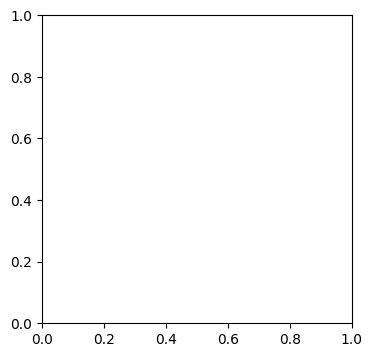

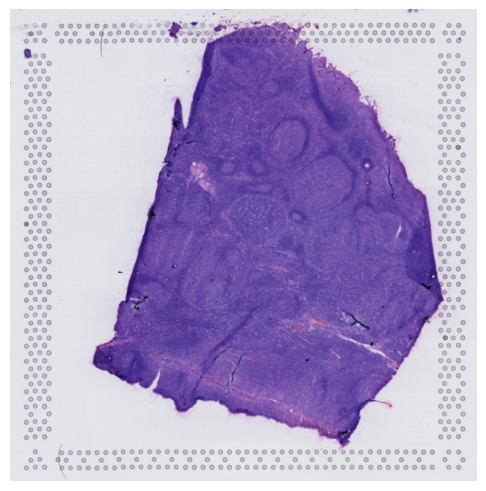

In [68]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
ax1 = sq.pl.spatial_scatter(inferred_atac_and_cell_types,return_ax=True,frameon=False)
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-spatial-tissue.png',dpi=600)

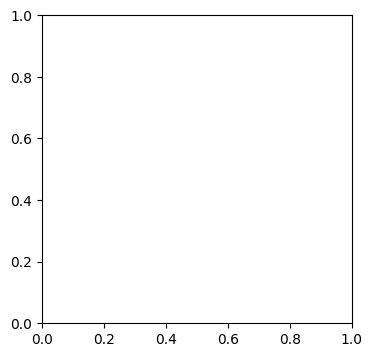

<Figure size 640x480 with 0 Axes>

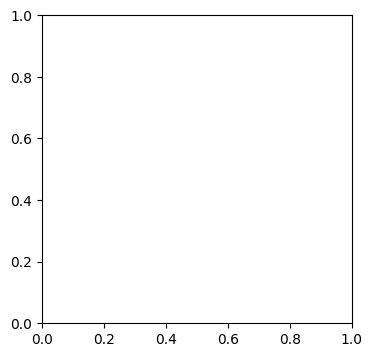

<Figure size 640x480 with 0 Axes>

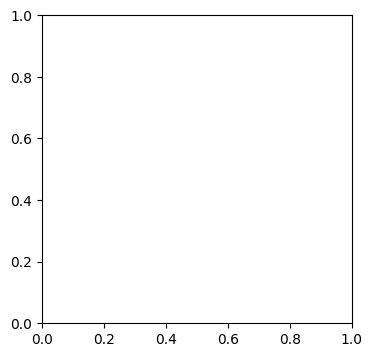

<Figure size 640x480 with 0 Axes>

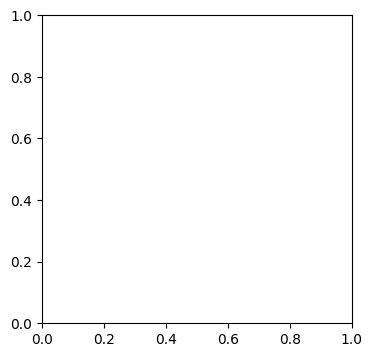

<Figure size 640x480 with 0 Axes>

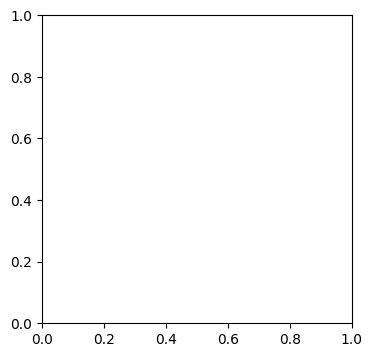

<Figure size 640x480 with 0 Axes>

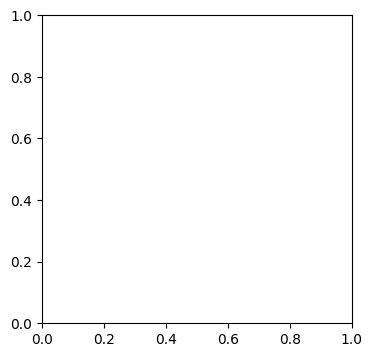

<Figure size 640x480 with 0 Axes>

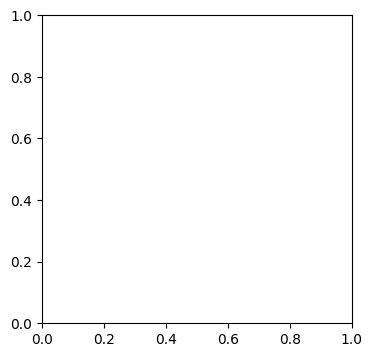

<Figure size 640x480 with 0 Axes>

In [66]:
for ctype in ['0','1','2','3','4','5','6']:
    fig,ax1 = plt.subplots(1,1)
    fig.set_size_inches(4,4)
    ax1 = sq.pl.spatial_scatter(inferred_atac_and_cell_types, 
    color=ctype,cmap='magma',
    size=1.7,img=False,frameon=False,return_ax=True,
    edges_width = 1,vmax=6)
    
    plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-spatial-with-inferred-celltype'+str(ctype)+'.png',dpi=600)
    plt.clf()

In [4]:
def calculate_neighbors(adata):
    # normalize and calculate leiden clustering
    sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6,transform='cosine')
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.pca(adata, n_comps=15)
    sc.pp.neighbors(adata)
    return adata

def joint_cluster(adata,proximity_weight=0.0,res=1):
    # Define the joint adjacency weighting
    joint_adj = adata.obsp['spatial_connectivities']*proximity_weight + adata.obsp['connectivities']
    sc.tl.leiden(adata,adjacency=joint_adj,key_added='joint_leiden_clusters',resolution=res)
    return adata

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


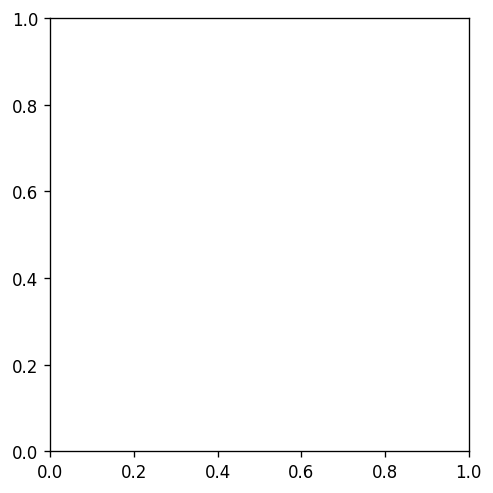

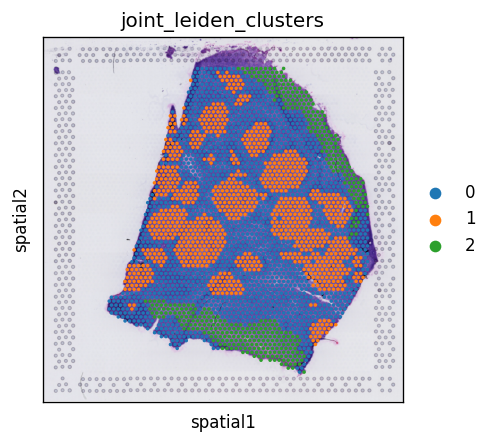

In [23]:

# resolution: 0.8
# weight_ 0.2
resolution = 0.3
weight = 0.2
adata = spatial_rna
adata = calculate_neighbors(adata)

adata = joint_cluster(adata,proximity_weight=weight,res=resolution)
try:
    sq.pl.spatial_scatter(adata,color=['joint_leiden_clusters'],size=1.2,figsize=(4,4),dpi=120)
#    plt.savefig(dir_path+'/'+sample_id+'_section_space_clusters_proximity_weight_'+str(weight)+'_resolution_'+str(resolution)+'.png')
#    plt.close()
#    sc.pl.scatter(adata,color=['joint_leiden_clusters'],size=1.2,figsize=(8,8),dpi=120)
#    plt.savefig(dir_path+'/'+sample_id+'_UMAP_space_clusters_proximity_weight_'+str(weight)+'_resolution_'+str(resolution)+'.png')
except:
    adata.uns.pop('joint_leiden_clusters_colors')
    sq.pl.spatial_scatter(adata,color=['joint_leiden_clusters'],size=1.2,figsize=(4,4),dpi=120)
#    plt.savefig(dir_path+'/'+sample_id+'_section_space_clusters_proximity_weight_'+str(weight)+'_resolution_'+str(resolution)+'.png')
#    plt.close()
#    sc.pl.scatter(adata,color=['joint_leiden_clusters'],size=1.2,figsize=(8,8),dpi=120)
#    plt.savefig(dir_path+'/'+sample_id+'_UMAP_space_clusters_proximity_weight_'+str(weight)+'_resolution_'+str(resolution)+'.png')

In [25]:
spatial_rna.obs.joint_leiden_clusters

AAACAAGTATCTCCCA-1    1
AAACACCAATAACTGC-1    0
AAACAGAGCGACTCCT-1    0
AAACATTTCCCGGATT-1    0
AAACCCGAACGAAATC-1    1
                     ..
TTGTTGTGTGTCAAGA-1    1
TTGTTTCACATCCAGG-1    0
TTGTTTCATTAGTCTA-1    0
TTGTTTCCATACAACT-1    0
TTGTTTGTGTAAATTC-1    0
Name: joint_leiden_clusters, Length: 3079, dtype: category
Categories (3, object): ['0', '1', '2']

In [53]:
spatial_rna.obs['tissue zone'] = spatial_rna.obs['joint_leiden_clusters'].map(
    {'0':'Inter-follicular zone',
    '1':'Follicle',
    '2':'Epithelial'})

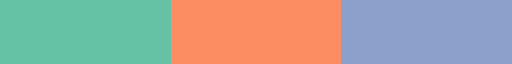

In [74]:
from matplotlib.colors import ListedColormap
set2 = plt.get_cmap('Set2')
set2 = ListedColormap(set2(np.arange(3)))
set2

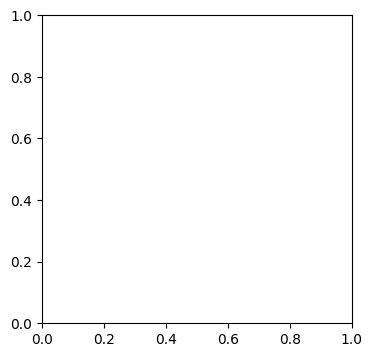

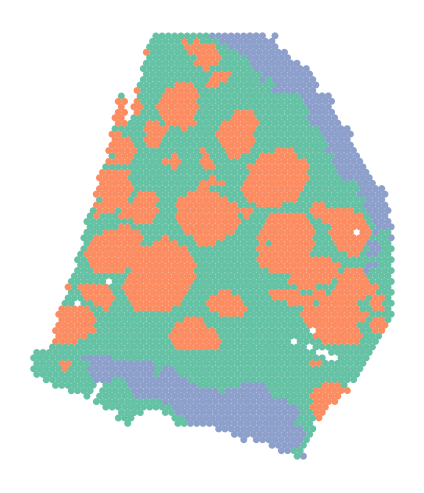

In [75]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
ax1 = sq.pl.spatial_scatter(adata,color=['tissue zone'],size=1.7,figsize=(4,4),dpi=120,
return_ax=True,frameon=False,palette=set2,img=False,legend_loc='none',title='')
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-spatial-with-expression-based-clustering.png',dpi=600)

In [54]:
inferred_atac_and_cell_types.obs['tissue zone'] = spatial_rna.obs['tissue zone']

In [80]:
df = inferred_atac_and_cell_types.obs
df.sort_values('tissue zone',inplace=True)
df

,3,0,4,2,1,6,5,tissue zone
TTGTTTGTGTAAATTC-1,0.0,0.0,0.0,0.0,5.0,0.0,0.0,Inter-follicular zone
CGCTTATTCCCGGTCG-1,3.0,1.0,0.0,1.0,1.0,0.0,0.0,Inter-follicular zone
TACTGAACAGATTTAG-1,2.0,1.0,1.0,1.0,0.0,1.0,1.0,Inter-follicular zone
CGCTGTGTGGATGTTG-1,1.0,2.0,1.0,1.0,2.0,1.0,2.0,Inter-follicular zone
CGCTGTGACGCCGCAC-1,2.0,1.0,1.0,1.0,1.0,2.0,1.0,Inter-follicular zone
...,...,...,...,...,...,...,...,...
ATTGACCGGCGATGAC-1,1.0,3.0,1.0,1.0,1.0,2.0,0.0,Epithelial
ATTCTGAGTATGAACT-1,1.0,2.0,2.0,1.0,1.0,1.0,1.0,Epithelial
TCTGATTGGAAATGGA-1,2.0,1.0,2.0,2.0,1.0,1.0,1.0,Epithelial
CAAACCCTCCGGCGGG-1,1.0,2.0,1.0,1.0,1.0,0.0,3.0,Epithelial


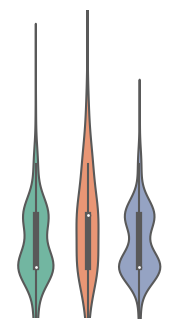

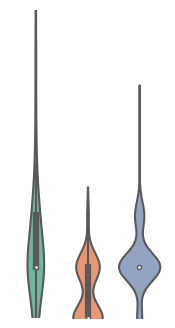

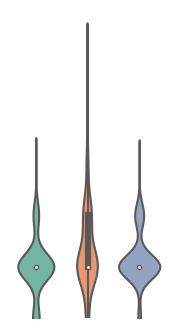

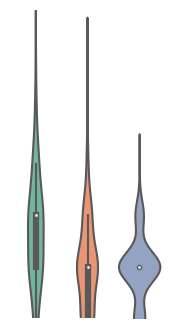

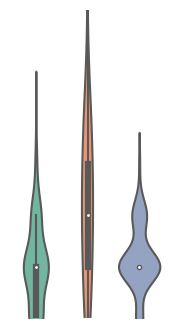

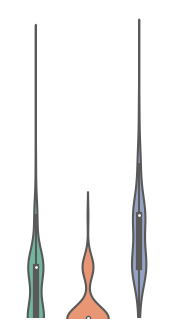

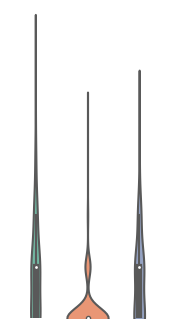

In [96]:
for ctype in ['0','1','2','3','4','5','6']:
    fig,ax1 = plt.subplots(1,1)
    fig.set_size_inches(2,4)
    sns.violinplot(df,y=ctype,x='tissue zone',bw=0.5,
    hue_order=['Follicle','Inter-follicular zone','Epithelial'],
    palette='Set2',ax=ax1)
    ax1.set_ylim(0,6)
    ax1.axis('off')
    plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-violinplot-split-by-cluster-atac-ctype-'+str(ctype)+'.png',dpi=600)

In [101]:
df

,3,0,4,2,1,6,5,tissue zone
TTGTTTGTGTAAATTC-1,0.0,0.0,0.0,0.0,5.0,0.0,0.0,Inter-follicular zone
CGCTTATTCCCGGTCG-1,3.0,1.0,0.0,1.0,1.0,0.0,0.0,Inter-follicular zone
TACTGAACAGATTTAG-1,2.0,1.0,1.0,1.0,0.0,1.0,1.0,Inter-follicular zone
CGCTGTGTGGATGTTG-1,1.0,2.0,1.0,1.0,2.0,1.0,2.0,Inter-follicular zone
CGCTGTGACGCCGCAC-1,2.0,1.0,1.0,1.0,1.0,2.0,1.0,Inter-follicular zone
...,...,...,...,...,...,...,...,...
ATTGACCGGCGATGAC-1,1.0,3.0,1.0,1.0,1.0,2.0,0.0,Epithelial
ATTCTGAGTATGAACT-1,1.0,2.0,2.0,1.0,1.0,1.0,1.0,Epithelial
TCTGATTGGAAATGGA-1,2.0,1.0,2.0,2.0,1.0,1.0,1.0,Epithelial
CAAACCCTCCGGCGGG-1,1.0,2.0,1.0,1.0,1.0,0.0,3.0,Epithelial


In [118]:
df.value_counts('tissue zone')

tissue zone
Inter-follicular zone    1577
Follicle                 1045
Epithelial                457
dtype: int64

In [137]:
#from scipy.stats import ranksums

clust = '2'
keys = ['Inter-follicular zone','Follicle','Epithelial']
key1 = keys[0]
key2 = keys[1]
ranksums(df[df['tissue zone'] == key1][clust],df[df['tissue zone'] == key2][clust])

RanksumsResult(statistic=-9.30859171734714, pvalue=1.2953844777645329e-20)

(0.0, 6.0)

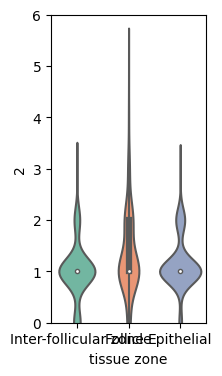

In [114]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(2,4)
sns.violinplot(df,y=clust,x='tissue zone',bw=0.5,
hue_order=['Follicle','Inter-follicular zone','Epithelial'],
palette='Set2',ax=ax1)
ax1.set_ylim(0,6)

In [155]:
gene_target = 'C1QA'
peak_locs = inferred_atac_and_cell_types[:,inferred_atac_and_cell_types.var['nearestGene'] == gene_target].var_names

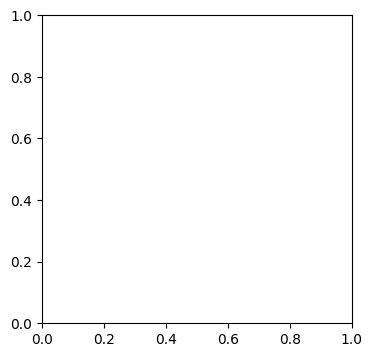

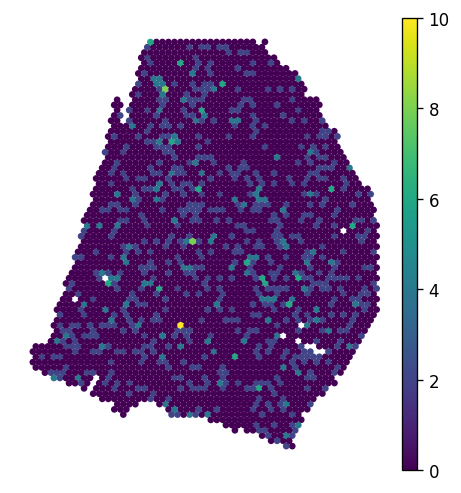

In [156]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
ax1 = sq.pl.spatial_scatter(inferred_atac_and_cell_types,color=peak_locs,size=1.7,figsize=(4,4),dpi=120,
return_ax=True,frameon=False,palette=set2,img=False,legend_loc='none',title='')
#plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-spatial-with-expression-based-clustering.png',dpi=600)
